<a href="https://colab.research.google.com/github/kridtapon/WFO-TEMA-Heikin-Momentum/blob/main/WFO_TEMA_Heikin_Momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninsta

[*********************100%***********************]  1 of 1 completed
<ipython-input-24-027134241116>:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-027134241116>:76: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-027134241116>:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide


Walk-Forward Optimization Results:
   Year       Best_Params  Test_Return
0  2020   (5, 9, 9, 5, 9)     0.902281
1  2021   (5, 9, 9, 5, 9)     0.258491
2  2022  (5, 5, 7, 3, 22)     0.146646
3  2023  (5, 1, 7, 9, 17)     0.274752
4  2024  (5, 1, 7, 7, 18)     0.505113
5  2025  (5, 1, 7, 7, 18)     0.000000
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           555262.240804
Total Return [%]                       455.262241
Benchmark Return [%]                   403.609123
Max Gross Exposure [%]                      100.0
Total Fees Paid                      27820.942113
Max Drawdown [%]                        34.413522
Max Drawdown Duration                       256.0
Total Trades                                   43
Total Closed Trades                            43
Total Open Trades                        

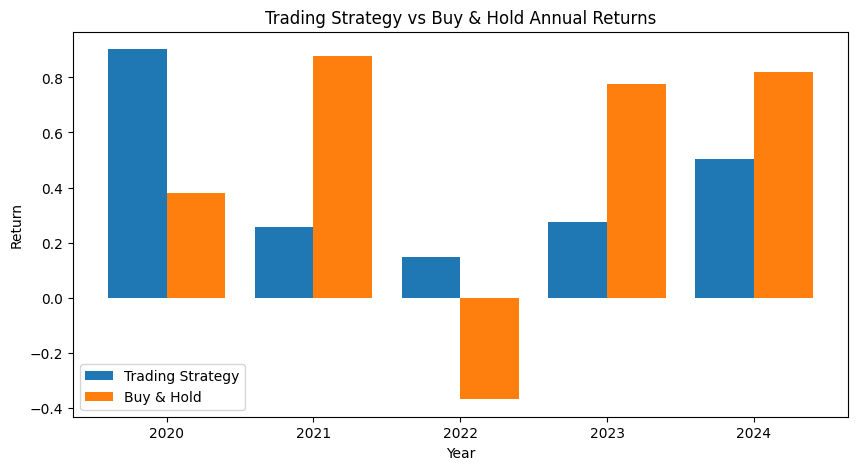

In [24]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import itertools

# Function to calculate Triple Exponential Moving Average (TEMA)
def calculate_tema(df, period=30):
    ema1 = df['Close'].ewm(span=period).mean()
    ema2 = ema1.ewm(span=period).mean()
    ema3 = ema2.ewm(span=period).mean()
    tema = 3 * (ema1 - ema2) + ema3
    return tema

# Function to calculate Heikin-Ashi candles
def calculate_heikin_ashi(df):
    ha_df = df.copy()

    # Calculate Heikin-Ashi Close
    ha_df['HA_Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
    # Calculate Heikin-Ashi Open
    ha_df['HA_Open'] = (df['Open'].shift(1) + df['Close'].shift(1)) / 2
    # Calculate Heikin-Ashi High
    ha_df['HA_High'] = ha_df[['High', 'HA_Open', 'HA_Close']].max(axis=1)
    # Calculate Heikin-Ashi Low
    ha_df['HA_Low'] = ha_df[['Low', 'HA_Open', 'HA_Close']].min(axis=1)

    # Ensure that 'HA_Open' and 'HA_Close' are in the DataFrame
    return ha_df

# Walk-forward optimization with TEMA
def walk_forward_optimization_tema(df, start_year, end_year):
    results = []

    entry_shift_1_range = range(1, 10, 2)
    entry_shift_2_range = range(1, 10, 2)
    exit_shift_1_range = range(1, 10, 2)
    exit_shift_2_range = range(1, 10, 2)
    tema_period_range = range(1, 31)

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1
        test_start = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        for params in itertools.product(entry_shift_1_range, entry_shift_2_range, exit_shift_1_range, exit_shift_2_range, tema_period_range):
            entry_shift_1, entry_shift_2, exit_shift_1, exit_shift_2, tema_period = params

            train_data['TEMA'] = calculate_tema(train_data, tema_period)

            # Use Heikin-Ashi Close for entry and exit signals
            entries = (train_data['HA_Close'].shift(entry_shift_1) > train_data['TEMA'].shift(entry_shift_2))
            exits = (train_data['HA_Close'].shift(exit_shift_1) < train_data['TEMA'].shift(exit_shift_2))

            portfolio = vbt.Portfolio.from_signals(
                close=train_data['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = (entry_shift_1, entry_shift_2, exit_shift_1, exit_shift_2, tema_period)

        yearly_data = df[(df.index.year >= test_year - 1) & (df.index.year <= test_year)]
        yearly_data['TEMA'] = calculate_tema(yearly_data, best_params[4])

        yearly_data = yearly_data[yearly_data.index.year == test_year]

        entries = (yearly_data['HA_Close'].shift(best_params[0]) > yearly_data['TEMA'].shift(best_params[1]))
        exits = (yearly_data['HA_Close'].shift(best_params[2]) < yearly_data['TEMA'].shift(best_params[3]))

        portfolio = vbt.Portfolio.from_signals(
            close=yearly_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'KKR' # AXON DECK KKR! PLTR! WMT SPY
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close','Close', 'High', 'Low', 'Open', 'Volume']

# Apply Heikin-Ashi calculation
df = calculate_heikin_ashi(df)

# Perform walk-forward optimization
results = walk_forward_optimization_tema(df, 2016, 2025)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    params = row['Best_Params']

    yearly_data = df[(df.index.year >= year - 1) & (df.index.year <= year)]
    yearly_data['TEMA'] = calculate_tema(yearly_data, params[4])

    # Keep only the second year to avoid missing values from indicator calculation
    yearly_data = yearly_data[yearly_data.index.year == year]

    entries = (yearly_data['HA_Close'].shift(params[0]) > yearly_data['TEMA'].shift(params[1]))
    exits = (yearly_data['HA_Close'].shift(params[2]) < yearly_data['TEMA'].shift(params[3]))

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Backtest using the combined signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

# Get unique years in the dataset
years = sorted(df.index.year.unique())

# Store annual returns
strategy_returns = {}
buy_and_hold_returns = {}

for year in years:
    yearly_data = df[df.index.year == year]

    if not yearly_data.empty:  # Check if data exists for the year
        # Buy & Hold Return
        start_price = yearly_data.iloc[0]['Close']
        end_price = yearly_data.iloc[-1]['Close']
        buy_and_hold_return = (end_price - start_price) / start_price
        buy_and_hold_returns[year] = buy_and_hold_return

        # Strategy Return
        strategy_returns[year] = results[results['Year'] == year]['Test_Return'].values[0]

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar([y - bar_width/2 for y in strategy_returns.keys()], strategy_returns.values(), width=bar_width, label="Trading Strategy")
plt.bar([y + bar_width/2 for y in buy_and_hold_returns.keys()], buy_and_hold_returns.values(), width=bar_width, label="Buy & Hold")

plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Trading Strategy vs Buy & Hold Annual Returns")
plt.legend()
plt.xticks(list(strategy_returns.keys()))

plt.show()


In [13]:
# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,503609.123036
Total Return [%],403.609123
Benchmark Return [%],403.609123
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],48.441248
